## Imports

In [1]:
import datetime
import os

In [2]:
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import *

In [3]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import *

Using TensorFlow backend.


## Config

In [4]:
RANDOM_SEED = 42

In [5]:
data_folder = os.path.abspath(os.path.join(os.curdir, os.pardir, 'data')) + os.path.sep
aux_data_folder = os.path.join(data_folder, 'aux') + os.path.sep
preproc_data_folder = os.path.join(data_folder, 'preproc') + os.path.sep
features_data_folder = os.path.join(data_folder, 'features') + os.path.sep
submissions_data_folder = os.path.join(data_folder, 'submissions') + os.path.sep

## Read Data

In [6]:
embedding_matrix = load(aux_data_folder + 'embedding_weights_fasttext_filtered_no_stopwords.pickle')

In [7]:
X_train_q1 = load(features_data_folder + 'X_train_nn_fasttext_q1_filtered_no_stopwords.pickle')
X_train_q2 = load(features_data_folder + 'X_train_nn_fasttext_q2_filtered_no_stopwords.pickle')

In [8]:
X = np.stack((X_train_q1, X_train_q2), axis=1)

In [9]:
y = load(features_data_folder + 'y_train.pickle')

In [10]:
EMBEDDING_DIM = embedding_matrix.shape[-1]
VOCAB_LENGTH = embedding_matrix.shape[0] - 1
MAX_SEQUENCE_LENGTH = X.shape[-1]

In [11]:
print(EMBEDDING_DIM, VOCAB_LENGTH, MAX_SEQUENCE_LENGTH)

300 101441 30


In [12]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.15,
    random_state=RANDOM_SEED,
    stratify=y
)

In [13]:
print('X train:', X_train.shape)
print('y train:', y_train.shape)
print('X val:  ', X_val.shape)
print('y val:  ', y_val.shape)

X train: (343646, 2, 30)
y train: (343646,)
X val:   (60644, 2, 30)
y val:   (60644,)


In [14]:
X_train_q1 = X_train[:, 0]
X_train_q2 = X_train[:, 1]
X_val_q1 = X_val[:, 0]
X_val_q2 = X_val[:, 1]

In [15]:
print('X train Q1:', X_train_q1.shape)
print('y train Q1:', X_train_q2.shape)
print('X val Q1:  ', X_val_q1.shape)
print('y val Q1:  ', X_val_q2.shape)

X train Q1: (343646, 30)
y train Q1: (343646, 30)
X val Q1:   (60644, 30)
y val Q1:   (60644, 30)


## Train Model

In [16]:
model_q1 = Sequential()

model_q1.add(Embedding(
    VOCAB_LENGTH + 1,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False,
))

model_q1.add(TimeDistributed(Dense(
    EMBEDDING_DIM,
    activation='relu',
)))

model_q1.add(Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, )))

In [17]:
model_q2 = Sequential()

model_q2.add(Embedding(
    VOCAB_LENGTH + 1,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False,
))

model_q2.add(TimeDistributed(Dense(
    EMBEDDING_DIM,
    activation='relu'
)))

model_q2.add(Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, )))

In [18]:
model = Sequential()
model.add(Merge([model_q1, model_q2], mode='concat'))

/home/yuriyguts/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  


In [19]:
model.add(BatchNormalization())
model.add(Dense(200, activation='relu'))

model.add(BatchNormalization())
model.add(Dense(200, activation='relu'))

model.add(BatchNormalization())
model.add(Dense(200, activation='relu'))

model.add(BatchNormalization())
model.add(Dense(200, activation='relu'))

model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

In [20]:
model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_1 (Merge)              (None, 600)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 600)               2400      
_________________________________________________________________
dense_3 (Dense)              (None, 200)               120200    
_________________________________________________________________
batch_normalization_2 (Batch (None, 200)               800       
_________________________________________________________________
dense_4 (Dense)              (None, 200)               40200     
_________________________________________________________________
batch_normalization_3 (Batch (None, 200)               800       
_________________________________________________________________
dense_5 (Dense)              (None, 200)               40200     
__________

In [22]:
def get_class_weights(y, smooth_factor=0):
    """
    Returns the weights for each class based on the frequencies of the samples
    :param smooth_factor: factor that smooths extremely uneven weights
    :param y: list of true labels (the labels must be hashable)
    :return: dictionary with the weight for each class
    """
    from collections import Counter    
    counter = Counter(y)

    if smooth_factor > 0:
        p = max(counter.values()) * smooth_factor
        for k in counter.keys():
            counter[k] += p

    majority = max(counter.values())

    return {cls: float(majority / count) for cls, count in counter.items()}

In [23]:
history = model.fit(
    [X_train_q1, X_train_q2], y_train,
    batch_size=64,
    epochs=15,
    validation_data=([X_val_q1, X_val_q2], y_val),
    class_weight=get_class_weights(y_train)
)

Train on 343646 samples, validate on 60644 samples
Epoch 1/15
343646/343646 [==============================] - 38s - loss: 0.6505 - acc: 0.7352 - val_loss: 0.4814 - val_acc: 0.7599
Epoch 2/15
343646/343646 [==============================] - 38s - loss: 0.5584 - acc: 0.7818 - val_loss: 0.4219 - val_acc: 0.7938
Epoch 3/15
343646/343646 [==============================] - 38s - loss: 0.5011 - acc: 0.8080 - val_loss: 0.4247 - val_acc: 0.7944
Epoch 4/15
343646/343646 [==============================] - 38s - loss: 0.4568 - acc: 0.8279 - val_loss: 0.4026 - val_acc: 0.8038
Epoch 5/15
343646/343646 [==============================] - 40s - loss: 0.4206 - acc: 0.8445 - val_loss: 0.3840 - val_acc: 0.8233
Epoch 6/15
343646/343646 [==============================] - 41s - loss: 0.3886 - acc: 0.8587 - val_loss: 0.4046 - val_acc: 0.8116
Epoch 7/15
343646/343646 [==============================] - 39s - loss: 0.3610 - acc: 0.8688 - val_loss: 0.4076 - val_acc: 0.8158
Epoch 8/15
343646/343646 [=============

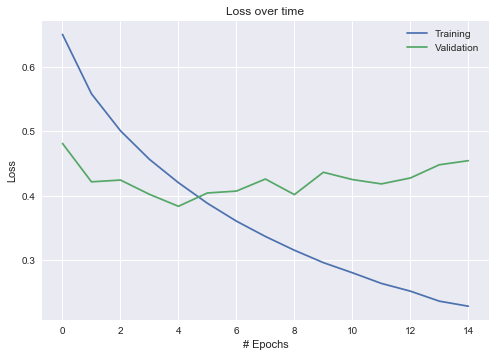

In [24]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
 
plt.xlabel("# Epochs")
plt.ylabel("Loss")
plt.legend(["Training", "Validation"])
plt.title("Loss over time")
 
plt.show()

## Evaluate Model

In [25]:
y_pred_train = model.predict_classes([X_train_q1, X_train_q2])[:, -1]
y_pred_proba_train = model.predict_proba([X_train_q1, X_train_q2])[:, -1]

343264/343646 [============================>.] - ETA: 0s

In [26]:
y_pred_val = model.predict_classes([X_val_q1, X_val_q2])[:, -1]
y_pred_proba_val = model.predict_proba([X_val_q1, X_val_q2])[:, -1]

60000/60644 [============================>.] - ETA: 0s

In [27]:
continuous_metrics = [log_loss, roc_auc_score]

In [28]:
binary_metrics = [accuracy_score, precision_score, recall_score]

### Train

In [29]:
for metric in continuous_metrics:
    print('{:20s}: {:10.5f}'.format(metric.__name__, metric(y_train, y_pred_proba_train)))
for metric in binary_metrics:
    print('{:20s}: {:10.5f}'.format(metric.__name__, metric(y_train, y_pred_train)))

log_loss            :    0.12979
roc_auc_score       :    0.99032
accuracy_score      :    0.95128
precision_score     :    0.90438
recall_score        :    0.97068


### Validation

In [30]:
for metric in continuous_metrics:
    print('{:20s}: {:10.5f}'.format(metric.__name__, metric(y_val, y_pred_proba_val)))
for metric in binary_metrics:
    print('{:20s}: {:10.5f}'.format(metric.__name__, metric(y_val, y_pred_val)))

log_loss            :    0.45742
roc_auc_score       :    0.90843
accuracy_score      :    0.83093
precision_score     :    0.74923
recall_score        :    0.81478


In [31]:
raise ValueError('Stopping before the test set')

ValueError: Stopping before the test set

### Test

In [ ]:
X_test_q1 = load(features_data_folder + 'X_test_nn_fasttext_q1_filtered_no_stopwords.pickle')
X_test_q2 = load(features_data_folder + 'X_test_nn_fasttext_q2_filtered_no_stopwords.pickle')

In [ ]:
y_test = model.predict_proba([X_test_q1, X_test_q2])[:, -1]

In [ ]:
submission_id = datetime.datetime.now().strftime('%Y-%m-%d-%H%M')

In [ ]:
df_submission = pd.DataFrame({
    'test_id': range(len(y_test)),
    'is_duplicate': y_test
})

In [ ]:
df_submission = df_submission[['test_id', 'is_duplicate']]

In [ ]:
df_submission.head(10)

In [ ]:
df_submission.to_csv(
    submissions_data_folder + submission_id + '-submission-draft.csv',
    header=True,
    float_format='%.8f',
    index=None,
)